#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/미니프로젝트6차/'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [6]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [7]:
sales_44 = sales[sales['Store_ID'] == 44]
sales_44.drop('Store_ID', axis=1, inplace=True)

In [8]:
orders_44 = orders[orders['Store_ID'] == 44]
orders_44.drop('Store_ID', axis=1, inplace=True)

In [9]:
print(oil_price.isna().sum())
oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='bfill')
print(oil_price.isna().sum())

Date          0
WTI_Price    30
dtype: int64
Date         0
WTI_Price    0
dtype: int64


## **(1) 상품 : 3 - Beverage**

In [10]:
lt_3 = products[products['Product_ID'] == 3]['LeadTime'].values[0]
print(lt_3)

2


In [11]:
sales_3 = sales_44[sales_44['Product_ID'] == 3]
sales_3.drop('Product_ID', axis=1, inplace=True)
sales_3 = pd.merge(sales_3, orders_44, on='Date')
sales_3 = pd.merge(sales_3, oil_price, on='Date')
sales_3['target'] = sales_3['Qty'].shift(-lt_3)
rows = []
for i in range(lt_3):
    rows.append(len(sales_3)-i-1)
sales_3.drop(rows, axis=0, inplace=True)
sales_3.head()

,Date,Qty,CustomerCount,WTI_Price,target
0,2014-01-02,9853.0,4422,95.14,7900.0
1,2014-01-03,8647.0,4167,93.66,7188.0
2,2014-01-06,7900.0,3917,93.12,8800.0
3,2014-01-07,7188.0,3663,93.31,6606.0
4,2014-01-08,8800.0,4254,91.90,7051.0


## **(2) 상품 : 12 - Milk**

In [12]:
lt_12 = products[products['Product_ID'] == 12]['LeadTime'].values[0]
print(lt_12)

2


In [13]:
sales_12 = sales_44[sales_44['Product_ID'] == 12]
sales_12.drop('Product_ID', axis=1, inplace=True)
sales_12 = pd.merge(sales_12, orders_44, on='Date')
sales_12 = pd.merge(sales_12, oil_price, on='Date')
sales_12['target'] = sales_12['Qty'].shift(-lt_12)
rows = []
for i in range(lt_12):
    rows.append(len(sales_12)-i-1)
sales_12.drop(rows, axis=0, inplace=True)
sales_12.head()

,Date,Qty,CustomerCount,WTI_Price,target
0,2014-01-02,9647.0,4422,95.14,7614.0
1,2014-01-03,8879.0,4167,93.66,7124.0
2,2014-01-06,7614.0,3917,93.12,8683.0
3,2014-01-07,7124.0,3663,93.31,6731.0
4,2014-01-08,8683.0,4254,91.90,6992.0


## **(3) 상품 : 42 - Agricultural products**

In [14]:
def decomp_plot(data, sdate, edate, period):
    # 시계열 데이터 분해
    temp = data.loc[(data['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model='additive', period=period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed': decomp.observed, 'trend': decomp.trend, 'seasonal': decomp.seasonal, 'residual': decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    # period만큼의 이동 평균
    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    # period를 하나의 cycle을 봄
    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

In [15]:
# 대상상품(42), 대상매장(44)에 필터링한 데이터이므로 products, stores 데이터는 병합해도 의미없을 것이라 판단
# 일별 유가의 경우 농산물의 Qty와 연관성이 있는 것처럼 보이지 않아 병합하지 않는 것으로 판단
# 일별 매장 고객 방문 수는 병합
sales_42 = sales_44[sales_44['Product_ID'] == 42]
temp = sales_42.merge(orders_44, on='Date', how='left')

# 판매 변화량(1일, 7일)
temp['Diff1'] = temp['Qty'].diff(periods=1)
temp['Diff7'] = temp['Qty'].diff(periods=7)

# 요일, 주말 여부, 월 추가
temp['Weekday'] = temp['Date'].dt.dayofweek
# temp['Month'] = temp['Date'].dt.month
temp['Weekend'] = np.where(temp['Weekday'] > 4, 1, 0)
# temp.drop(columns=['Weekday'], inplace=True)

# lag7:일주일 전 데이터, 일주일 주기성
# MA7: 7일 간 이동평균, 데이터의 변동을 부드럽게 하고 추세를 파악
temp['lag7'] = temp['Qty'].shift(periods=7)
temp['MA7'] = temp['Qty'].rolling(window=7).mean()

# Seasonal7: 1주일 주기의 계절성 (1주일 동안의 변동성, 월요일부터 일요일까지의 변화 분석)
# Seasonal28: 1달 주기의 계절성 (1달 동안의 변동성, 월별 변화 분석)
# 7일 주기로 계절성 분해
decomp7 = sm.tsa.seasonal_decompose(temp['Qty'], model='additive', period=7)
temp['Seasonal7'] = decomp7.seasonal
# 28일 주기로 계절성 분해
decomp28 = sm.tsa.seasonal_decompose(temp['Qty'], model='additive', period=28)
temp['Seasonal28'] = decomp28.seasonal

# 정답 레이블 생성 (LeadTime 이후 판매량)
leadtime = products.loc[(products['Product_ID'] == 42), 'LeadTime'].values[0]
temp['target'] = temp['Qty'].shift(-leadtime)

display(temp.head(8))

,Date,Qty,Product_ID,CustomerCount,Diff1,Diff7,Weekday,Weekend,lag7,MA7,Seasonal7,Seasonal28,target
0,2014-01-01,51.0,42,NaN,NaN,NaN,2,0,NaN,NaN,-8.419806,-7.844778,74.0
1,2014-01-02,76.0,42,4422.0,25.0,NaN,3,0,NaN,NaN,-0.937227,-1.817992,78.0
2,2014-01-03,74.0,42,4167.0,-2.0,NaN,4,0,NaN,NaN,7.709985,1.309240,88.0
3,2014-01-04,78.0,42,5341.0,4.0,NaN,5,1,NaN,NaN,13.207858,13.163258,65.0
4,2014-01-05,88.0,42,5123.0,10.0,NaN,6,1,NaN,NaN,20.790125,18.742722,78.0
5,2014-01-06,65.0,42,3917.0,-23.0,NaN,0,0,NaN,NaN,-23.015624,-23.804153,73.0
6,2014-01-07,78.0,42,3663.0,13.0,NaN,1,0,NaN,72.857143,-9.335311,-10.217546,78.0
7,2014-01-08,73.0,42,4254.0,-5.0,22.0,2,0,51.0,76.000000,-8.419806,-8.948349,96.0


In [16]:
temp.isnull().sum()

Date             0
Qty              0
Product_ID       0
CustomerCount    9
Diff1            1
Diff7            7
Weekday          0
Weekend          0
lag7             7
MA7              6
Seasonal7        0
Seasonal28       0
target           2
dtype: int64

In [17]:
sales_42 = temp.copy()

# 첫 7행과 끝 두 행은 삭제
sales_42 = sales_42[7:-2].reset_index(drop=True)

# CustomerCount는 선형보간법으로 진행
sales_42['CustomerCount'] = sales_42['CustomerCount'].interpolate(method='linear')

print(sales_42.info())
print('=' * 50)
display(sales_42.head(3))
print('=' * 50)
display(sales_42.tail(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1146 entries, 0 to 1145
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1146 non-null   datetime64[ns]
 1   Qty            1146 non-null   float64       
 2   Product_ID     1146 non-null   int64         
 3   CustomerCount  1146 non-null   float64       
 4   Diff1          1146 non-null   float64       
 5   Diff7          1146 non-null   float64       
 6   Weekday        1146 non-null   int32         
 7   Weekend        1146 non-null   int64         
 8   lag7           1146 non-null   float64       
 9   MA7            1146 non-null   float64       
 10  Seasonal7      1146 non-null   float64       
 11  Seasonal28     1146 non-null   float64       
 12  target         1146 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int32(1), int64(2)
memory usage: 112.0 KB
None


,Date,Qty,Product_ID,CustomerCount,Diff1,Diff7,Weekday,Weekend,lag7,MA7,Seasonal7,Seasonal28,target
0,2014-01-08,73.0,42,4254.0,-5.0,22.0,2,0,51.0,76.000000,-8.419806,-8.948349,96.0
1,2014-01-09,78.0,42,3723.0,5.0,2.0,3,0,76.0,76.285714,-0.937227,-1.004599,67.0
2,2014-01-10,96.0,42,4010.0,18.0,22.0,4,0,74.0,79.428571,7.709985,9.904776,93.0


,Date,Qty,Product_ID,CustomerCount,Diff1,Diff7,Weekday,Weekend,lag7,MA7,Seasonal7,Seasonal28,target
1143,2017-02-24,91.0,42,4549.0,-7.0,-18.0,4,0,109.0,90.428571,7.709985,1.309240,108.0
1144,2017-02-25,105.0,42,4619.0,14.0,12.0,5,1,93.0,92.142857,13.207858,13.163258,78.0
1145,2017-02-26,108.0,42,3877.0,3.0,-1.0,6,1,109.0,92.000000,20.790125,18.742722,87.0


In [18]:
cat_cols = [
            'Weekday',
            # 'Month',
            'Weekend'
            ]
sales_42 = pd.get_dummies(sales_42, columns=cat_cols, drop_first=True, dtype=int)
display(sales_42.head(3))
print('=' * 50)
display(sales_42.tail(3))

,Date,Qty,Product_ID,CustomerCount,Diff1,Diff7,lag7,MA7,Seasonal7,Seasonal28,target,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Weekend_1
0,2014-01-08,73.0,42,4254.0,-5.0,22.0,51.0,76.000000,-8.419806,-8.948349,96.0,0,1,0,0,0,0,0
1,2014-01-09,78.0,42,3723.0,5.0,2.0,76.0,76.285714,-0.937227,-1.004599,67.0,0,0,1,0,0,0,0
2,2014-01-10,96.0,42,4010.0,18.0,22.0,74.0,79.428571,7.709985,9.904776,93.0,0,0,0,1,0,0,0


,Date,Qty,Product_ID,CustomerCount,Diff1,Diff7,lag7,MA7,Seasonal7,Seasonal28,target,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Weekend_1
1143,2017-02-24,91.0,42,4549.0,-7.0,-18.0,109.0,90.428571,7.709985,1.309240,108.0,0,0,0,1,0,0,0
1144,2017-02-25,105.0,42,4619.0,14.0,12.0,93.0,92.142857,13.207858,13.163258,78.0,0,0,0,0,1,0,1
1145,2017-02-26,108.0,42,3877.0,3.0,-1.0,109.0,92.000000,20.790125,18.742722,87.0,0,0,0,0,0,1,1


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


In [19]:
scaler = MinMaxScaler()

## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [20]:
X = sales_3.drop(['Date', 'target'], axis=1)
y = sales_3['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=60, shuffle=False)

X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
y_train_s = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid_s = scaler.transform(y_valid.values.reshape(-1, 1))
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(757, 3) (60, 3) (757,) (60,)


### **2) 모델링**

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=50, verbose=1)

In [22]:
nfeatures = X_train_s.shape[1]

In [23]:
clear_session()

model = Sequential([Dense(16, input_shape=(nfeatures, ), activation='relu'),
                   Dense(1)])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                64        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (324.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
hist = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=10000, callbacks=[es]).history

Epoch 1/10000
24/24 [==============================] - 1s 9ms/step - loss: 0.0616 - val_loss: 0.0687
Epoch 2/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0225 - val_loss: 0.0303
Epoch 3/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0179
Epoch 4/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0155
Epoch 5/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0155
Epoch 6/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0155
Epoch 7/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0152
Epoch 8/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0151
Epoch 9/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0151
Epoch 10/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0083 - val_lo

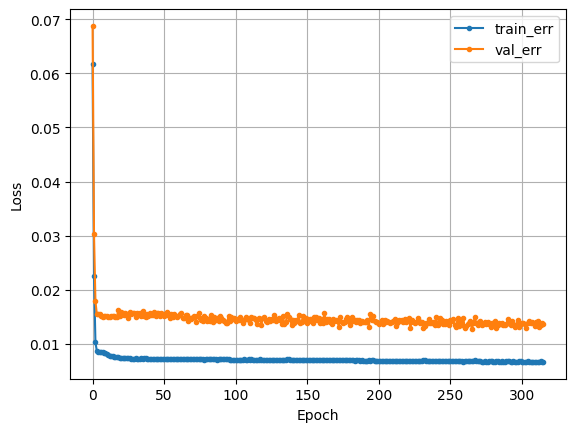

In [25]:
dl_history_plot(hist)

2/2 [==============================] - 0s 4ms/step


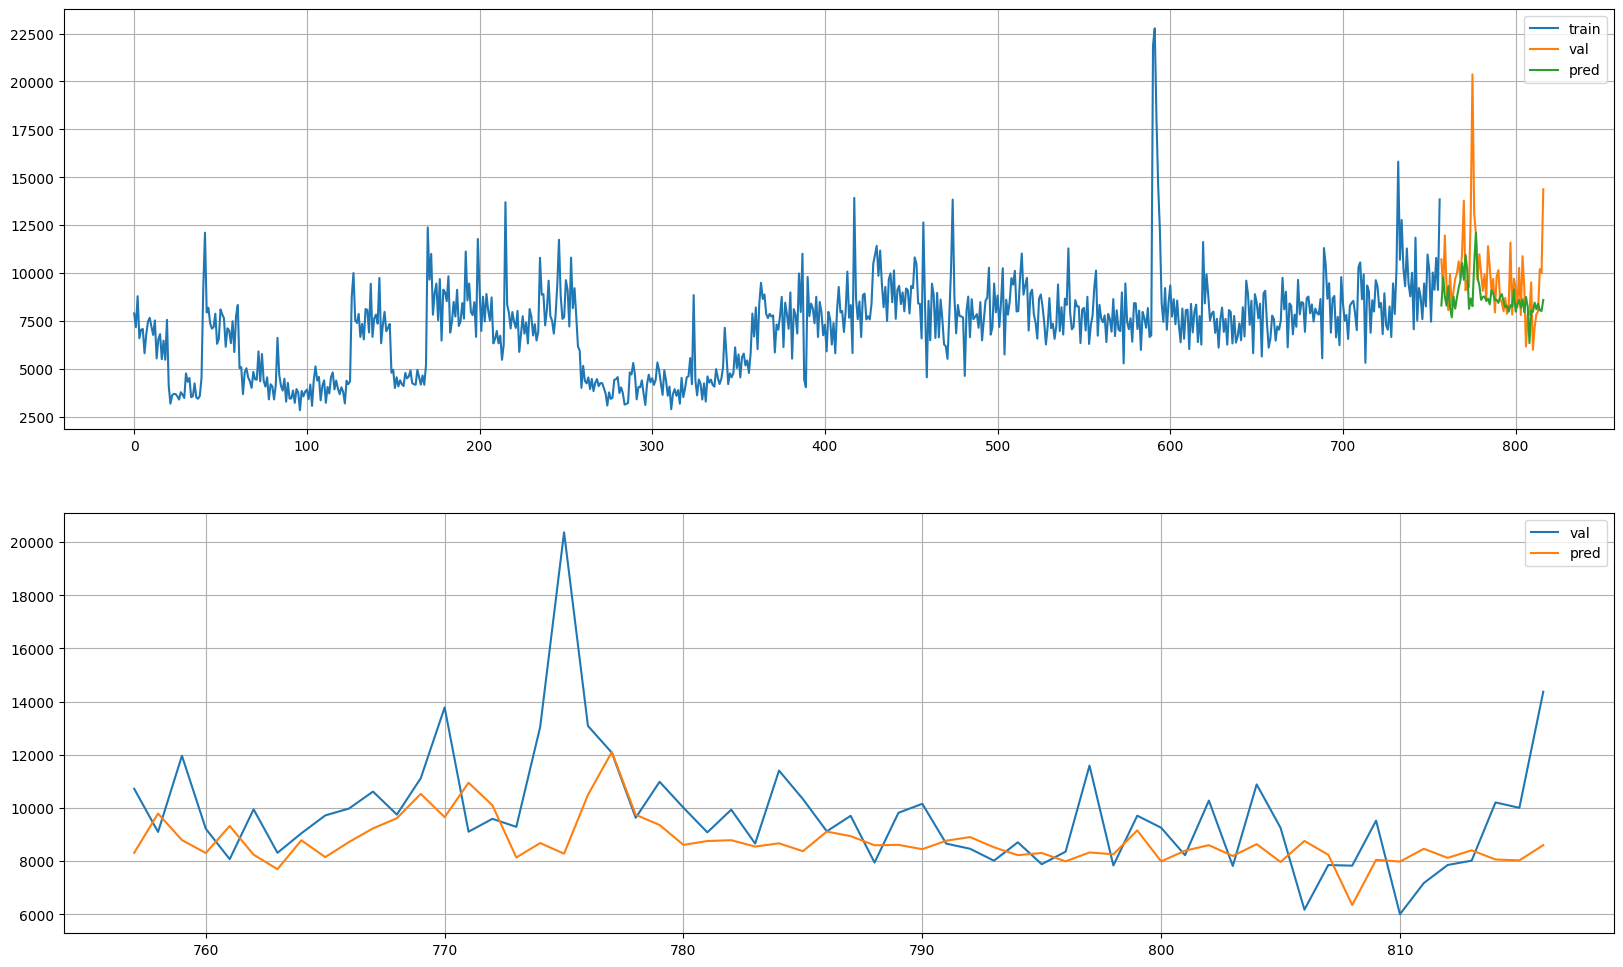

In [26]:
y_pred = model.predict(X_valid_s)
y_pred = scaler.inverse_transform(y_pred)

plot_model_result(y_train, y_valid, y_pred)

In [27]:
print('RMSE :', mean_squared_error(y_valid, y_pred))
print('MAE :', mean_absolute_error(y_valid, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_valid, y_pred))
print('R2  :', r2_score(y_valid, y_pred))

RMSE : 5457441.1706918795
MAE : 1496.0472005208333
MAPE: 0.13888141847438332
R2  : -0.17568628143104137


## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [28]:
X = sales_12.drop(['Date', 'target'], axis=1)
y = sales_12['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=60, shuffle=False)

X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
y_train_s = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid_s = scaler.transform(y_valid.values.reshape(-1, 1))
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(757, 3) (60, 3) (757,) (60,)


### **2) 모델링**

In [29]:
nfeatures = X_train_s.shape[1]

In [30]:
clear_session()

model = Sequential([Dense(16, input_shape=(nfeatures, ), activation='relu'),
                   Dense(1)])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                64        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (324.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
hist = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=10000, callbacks=[es]).history

Epoch 1/10000
24/24 [==============================] - 1s 7ms/step - loss: 0.0581 - val_loss: 0.0429
Epoch 2/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0173
Epoch 3/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0127
Epoch 4/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0126
Epoch 5/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0125
Epoch 6/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0123
Epoch 7/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0118
Epoch 8/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0114
Epoch 9/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0115
Epoch 10/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0063 - val_lo

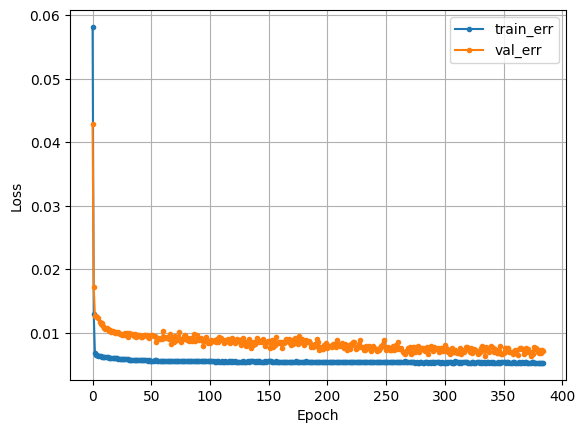

In [32]:
dl_history_plot(hist)

2/2 [==============================] - 0s 4ms/step


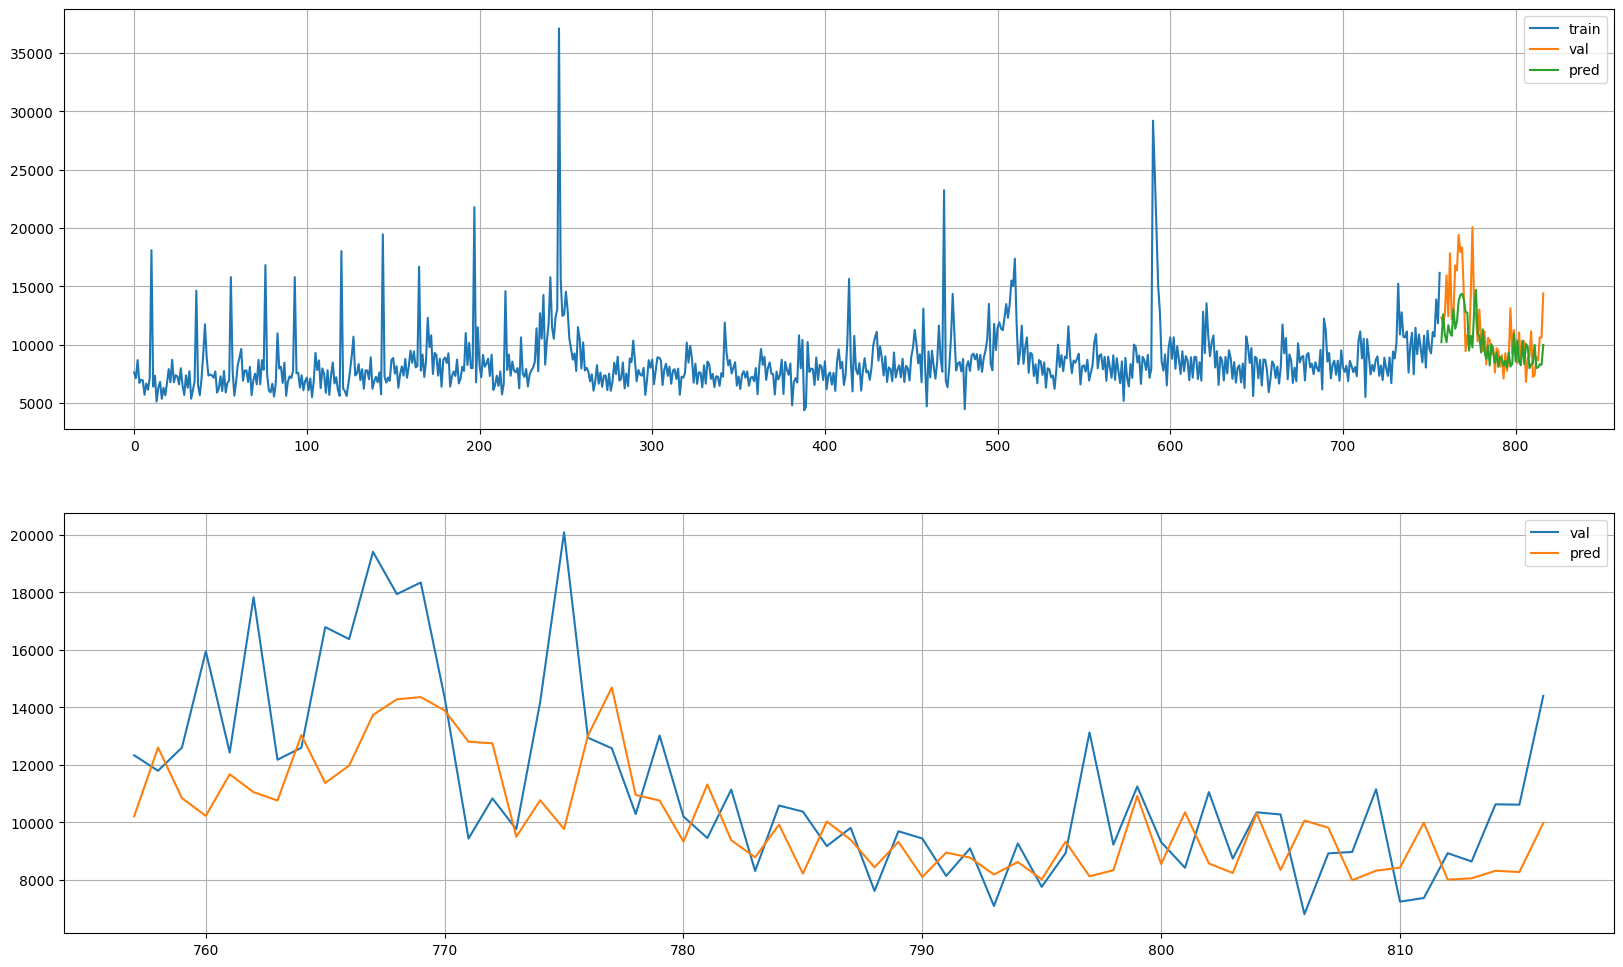

In [33]:
y_pred = model.predict(X_valid_s)
y_pred = scaler.inverse_transform(y_pred)

plot_model_result(y_train, y_valid, y_pred)

In [34]:
print('RMSE :', mean_squared_error(y_valid, y_pred))
print('MAE :', mean_absolute_error(y_valid, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_valid, y_pred))
print('R2  :', r2_score(y_valid, y_pred))

RMSE : 7703383.484083363
MAE : 1984.0053629557292
MAPE: 0.1613969816066499
R2  : 0.23686128812971574


## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [35]:
X = sales_42.drop(['Date', 'target'], axis=1)
y = sales_42['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=60, shuffle=False)

X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
y_train_s = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid_s = scaler.transform(y_valid.values.reshape(-1, 1))
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(1086, 16) (60, 16) (1086,) (60,)


### **2) 모델링**

In [36]:
nfeatures = X_train_s.shape[1]

In [37]:
clear_session()

model = Sequential([Dense(16, input_shape=(nfeatures, ), activation='relu'),
                   Dense(1)])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 289 (1.13 KB)
Trainable params: 289 (1.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
hist = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=10000, callbacks=[es]).history

Epoch 1/10000
34/34 [==============================] - 1s 5ms/step - loss: 0.2471 - val_loss: 0.0958
Epoch 2/10000
34/34 [==============================] - 0s 2ms/step - loss: 0.0884 - val_loss: 0.0467
Epoch 3/10000
34/34 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0264
Epoch 4/10000
34/34 [==============================] - 0s 3ms/step - loss: 0.0227 - val_loss: 0.0167
Epoch 5/10000
34/34 [==============================] - 0s 2ms/step - loss: 0.0148 - val_loss: 0.0119
Epoch 6/10000
34/34 [==============================] - 0s 4ms/step - loss: 0.0114 - val_loss: 0.0099
Epoch 7/10000
34/34 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 8/10000
34/34 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0083
Epoch 9/10000
34/34 [==============================] - 0s 4ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 10/10000
34/34 [==============================] - 0s 4ms/step - loss: 0.0088 - val_lo

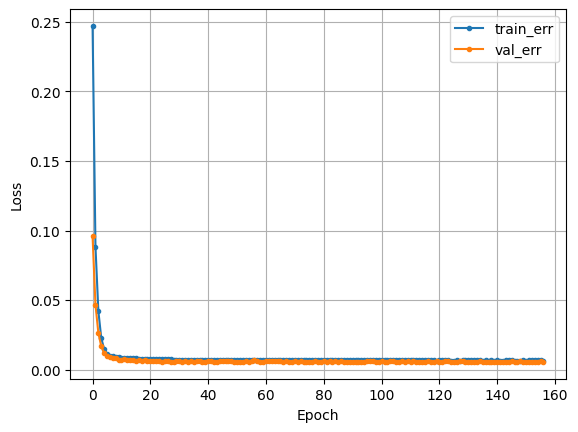

In [39]:
dl_history_plot(hist)

2/2 [==============================] - 0s 3ms/step


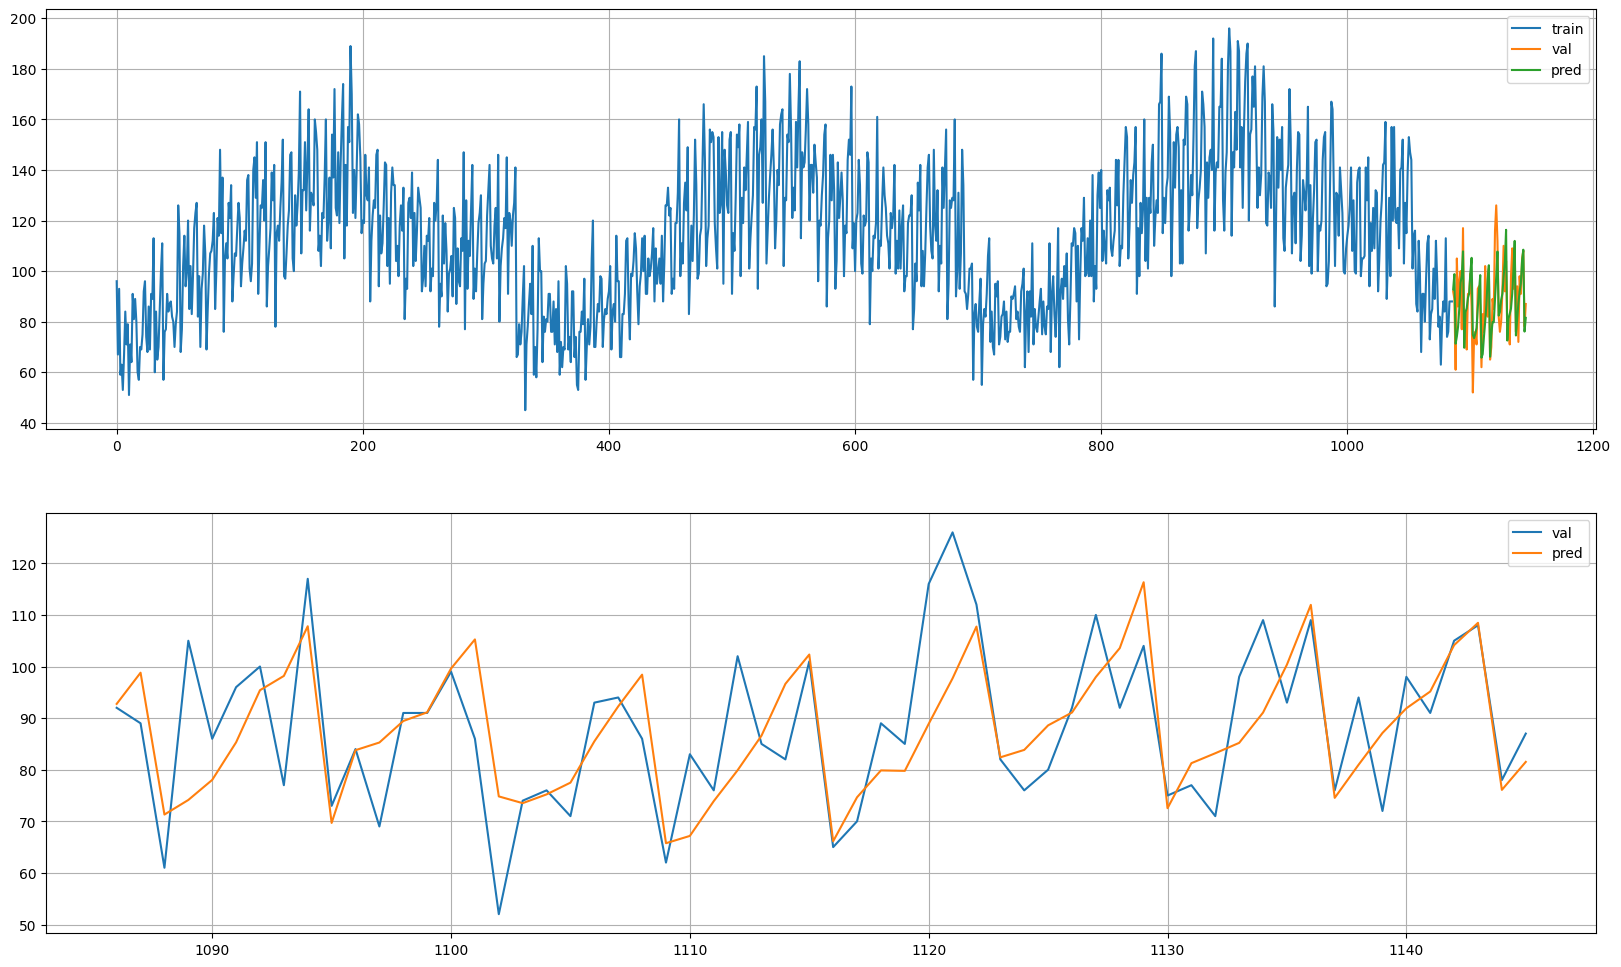

In [40]:
y_pred = model.predict(X_valid_s)
y_pred = scaler.inverse_transform(y_pred)

plot_model_result(y_train, y_valid, y_pred)

In [41]:
print('RMSE :', mean_squared_error(y_valid, y_pred))
print('MAE :', mean_absolute_error(y_valid, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_valid, y_pred))
print('R2  :', r2_score(y_valid, y_pred))

RMSE : 129.26290145562962
MAE : 8.37204844156901
MAPE: 0.09624114652556652
R2  : 0.4379948512274999


# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [42]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [43]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [44]:
timesteps = 30
val_size = 60

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [45]:
X = sales_3.drop(['Date', 'target'], axis=1)
y = sales_3['target']
X_3, y_3 = temporalize(X, y, timesteps)

X_train, X_valid, y_train, y_valid = train_test_split(X_3, y_3, test_size = val_size, shuffle = False)

scaler = MinMaxScaler().fit(flatten(X_train))
X_train_s = scale(X_train, scaler)
X_valid_s = scale(X_valid, scaler)
y_train_s = scaler.fit_transform(y_train.reshape(-1, 1))
y_valid_s = scaler.transform(y_valid.reshape(-1, 1))
print(X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape)

(728, 30, 3) (60, 30, 3) (728, 1) (60, 1)


* **모델링**

In [46]:
n_features = X_train_s.shape[2]

clear_session()

model = Sequential([LSTM(32, input_shape = (timesteps, n_features)),
                    Dense(1)])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
hist = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=10000, callbacks=[es]).history

Epoch 1/10000
23/23 [==============================] - 3s 32ms/step - loss: 0.0537 - val_loss: 0.0238
Epoch 2/10000
23/23 [==============================] - 0s 11ms/step - loss: 0.0162 - val_loss: 0.0249
Epoch 3/10000
23/23 [==============================] - 0s 12ms/step - loss: 0.0107 - val_loss: 0.0160
Epoch 4/10000
23/23 [==============================] - 0s 12ms/step - loss: 0.0094 - val_loss: 0.0132
Epoch 5/10000
23/23 [==============================] - 0s 11ms/step - loss: 0.0089 - val_loss: 0.0133
Epoch 6/10000
23/23 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0138
Epoch 7/10000
23/23 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0148
Epoch 8/10000
23/23 [==============================] - 0s 13ms/step - loss: 0.0079 - val_loss: 0.0143
Epoch 9/10000
23/23 [==============================] - 0s 20ms/step - loss: 0.0079 - val_loss: 0.0144
Epoch 10/10000
23/23 [==============================] - 0s 20ms/step - loss: 0.007

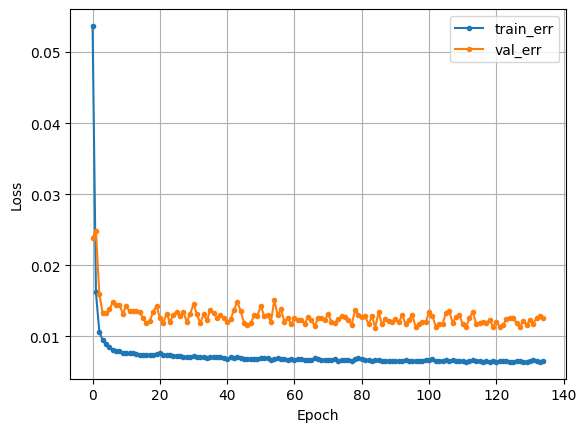

In [48]:
dl_history_plot(hist)

2/2 [==============================] - 0s 7ms/step


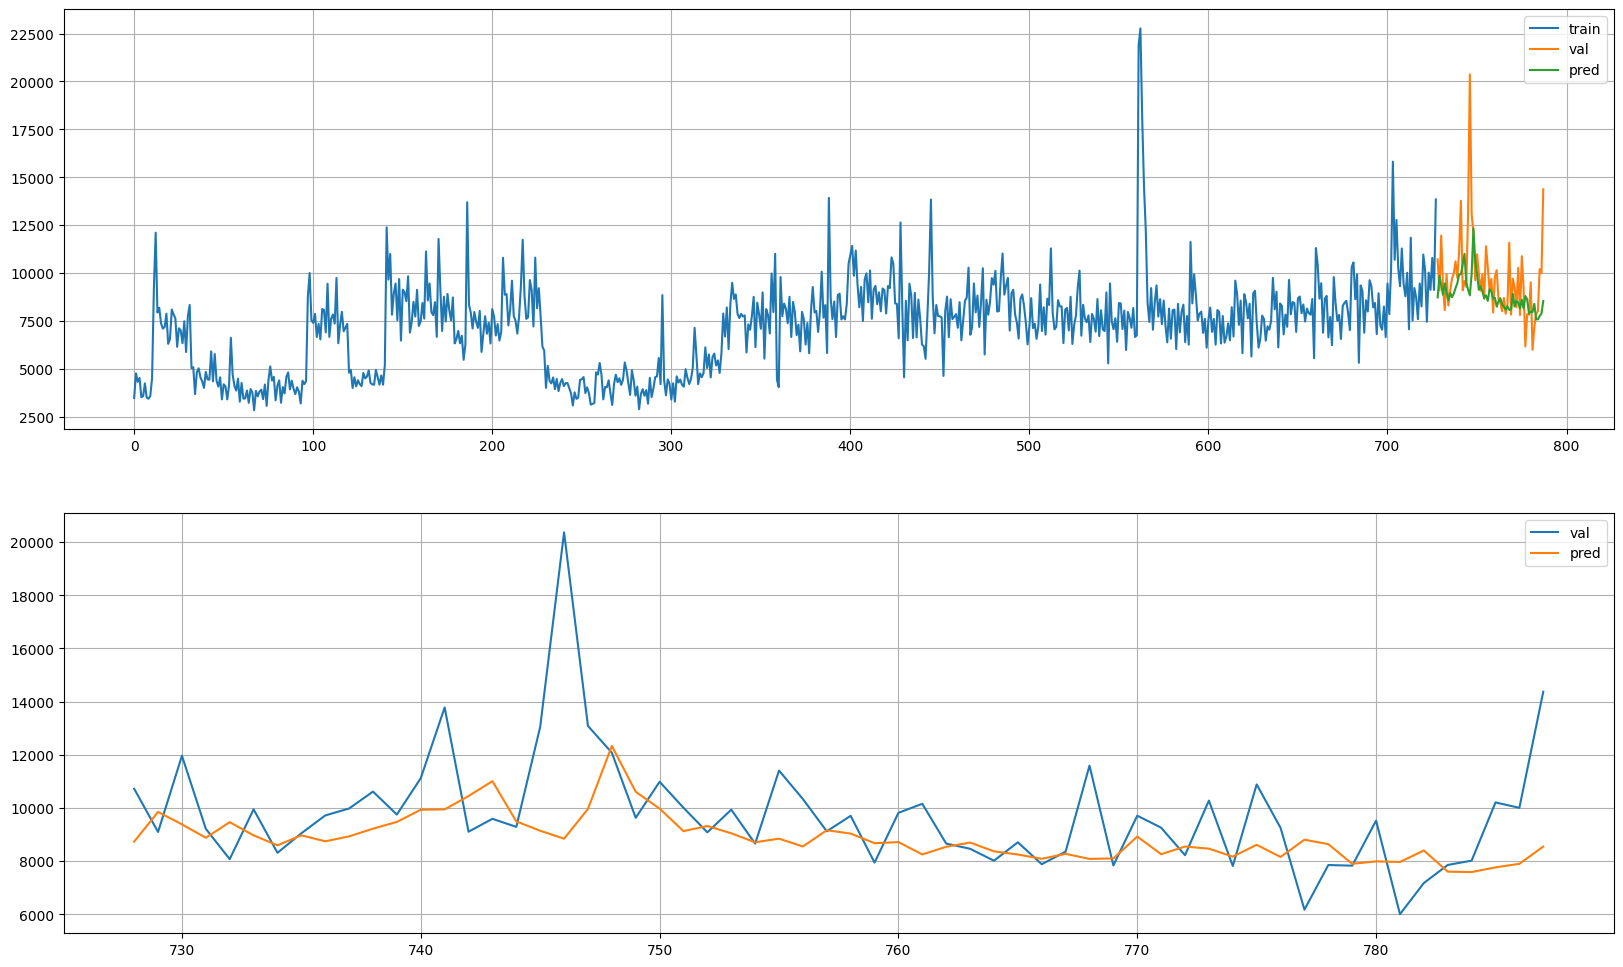

In [49]:
y_pred = model.predict(X_valid_s)
y_pred = scaler.inverse_transform(y_pred)

plot_model_result(y_train, y_valid, y_pred)

In [50]:
print('RMSE :', mean_squared_error(y_valid, y_pred))
print('MAE :', mean_absolute_error(y_valid, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_valid, y_pred))
print('R2  :', r2_score(y_valid, y_pred))

RMSE : 4992381.534956073
MAE : 1397.24150390625
MAPE: 0.1285198280971872
R2  : -0.0754993592671902


### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [51]:
X = sales_12.drop(['Date', 'target'], axis=1)
y = sales_12['target']
X_12, y_12 = temporalize(X, y, timesteps)

X_train, X_valid, y_train, y_valid = train_test_split(X_12, y_12, test_size = val_size, shuffle = False)

scaler = MinMaxScaler().fit(flatten(X_train))
X_train_s = scale(X_train, scaler)
X_valid_s = scale(X_valid, scaler)
y_train_s = scaler.fit_transform(y_train.reshape(-1, 1))
y_valid_s = scaler.transform(y_valid.reshape(-1, 1))
print(X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape)

(728, 30, 3) (60, 30, 3) (728, 1) (60, 1)


* **모델링**

In [52]:
n_features = X_train_s.shape[2]

clear_session()

model = Sequential([LSTM(32, input_shape = (timesteps, n_features)),
                    Dense(1)])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
hist = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=10000, callbacks=[es]).history

Epoch 1/10000
23/23 [==============================] - 5s 51ms/step - loss: 0.0118 - val_loss: 0.0128
Epoch 2/10000
23/23 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0097
Epoch 3/10000
23/23 [==============================] - 0s 16ms/step - loss: 0.0060 - val_loss: 0.0101
Epoch 4/10000
23/23 [==============================] - 0s 17ms/step - loss: 0.0059 - val_loss: 0.0105
Epoch 5/10000
23/23 [==============================] - 0s 17ms/step - loss: 0.0059 - val_loss: 0.0092
Epoch 6/10000
23/23 [==============================] - 0s 12ms/step - loss: 0.0059 - val_loss: 0.0107
Epoch 7/10000
23/23 [==============================] - 0s 11ms/step - loss: 0.0058 - val_loss: 0.0099
Epoch 8/10000
23/23 [==============================] - 0s 11ms/step - loss: 0.0058 - val_loss: 0.0087
Epoch 9/10000
23/23 [==============================] - 0s 11ms/step - loss: 0.0058 - val_loss: 0.0083
Epoch 10/10000
23/23 [==============================] - 0s 11ms/step - loss: 0.005

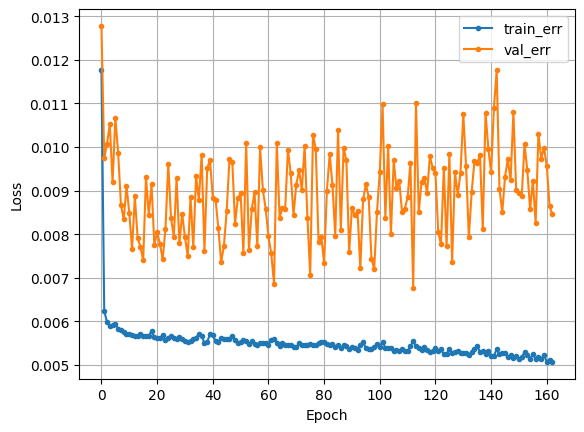

In [54]:
dl_history_plot(hist)

2/2 [==============================] - 0s 8ms/step


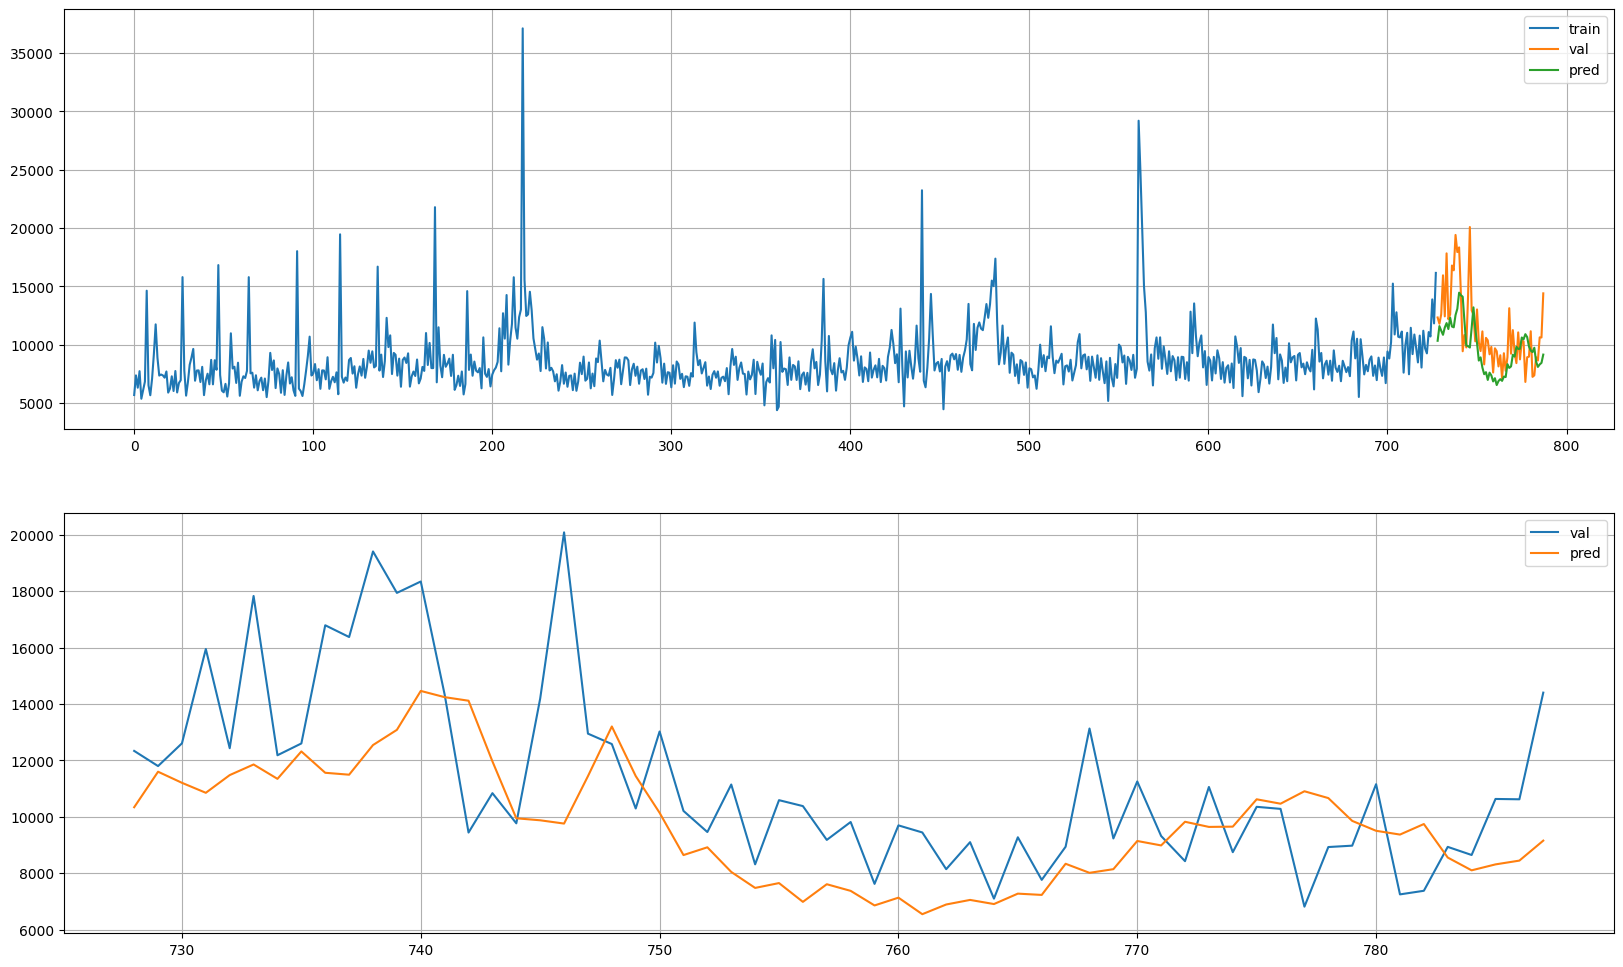

In [55]:
y_pred = model.predict(X_valid_s)
y_pred = scaler.inverse_transform(y_pred)

plot_model_result(y_train, y_valid, y_pred)

In [56]:
print('RMSE :', mean_squared_error(y_valid, y_pred))
print('MAE :', mean_absolute_error(y_valid, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_valid, y_pred))
print('R2  :', r2_score(y_valid, y_pred))

RMSE : 9049451.806524746
MAE : 2248.587060546875
MAPE: 0.1877411050831012
R2  : 0.10351250083387675


### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [57]:
X = sales_42.drop(['Date', 'target'], axis=1)
y = sales_42['target']
X_42, y_42 = temporalize(X, y, timesteps)

X_train, X_valid, y_train, y_valid = train_test_split(X_42, y_42, test_size = val_size, shuffle = False)

scaler = MinMaxScaler().fit(flatten(X_train))
X_train_s = scale(X_train, scaler)
X_valid_s = scale(X_valid, scaler)
y_train_s = scaler.fit_transform(y_train.reshape(-1, 1))
y_valid_s = scaler.transform(y_valid.reshape(-1, 1))
print(X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape)

(1057, 30, 16) (60, 30, 16) (1057, 1) (60, 1)


* **모델링**

In [58]:
n_features = X_train_s.shape[2]

clear_session()

model = Sequential([LSTM(32, input_shape = (timesteps, n_features)),
                    Dense(1)])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                6272      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 6305 (24.63 KB)
Trainable params: 6305 (24.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
hist = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=10000, callbacks=[es]).history

Epoch 1/10000
34/34 [==============================] - 3s 24ms/step - loss: 0.0907 - val_loss: 0.0160
Epoch 2/10000
34/34 [==============================] - 0s 11ms/step - loss: 0.0213 - val_loss: 0.0153
Epoch 3/10000
34/34 [==============================] - 0s 11ms/step - loss: 0.0139 - val_loss: 0.0110
Epoch 4/10000
34/34 [==============================] - 0s 11ms/step - loss: 0.0105 - val_loss: 0.0083
Epoch 5/10000
34/34 [==============================] - 0s 10ms/step - loss: 0.0091 - val_loss: 0.0068
Epoch 6/10000
34/34 [==============================] - 0s 10ms/step - loss: 0.0084 - val_loss: 0.0065
Epoch 7/10000
34/34 [==============================] - 0s 10ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 8/10000
34/34 [==============================] - 0s 10ms/step - loss: 0.0078 - val_loss: 0.0063
Epoch 9/10000
34/34 [==============================] - 0s 11ms/step - loss: 0.0073 - val_loss: 0.0062
Epoch 10/10000
34/34 [==============================] - 0s 11ms/step - loss: 0.007

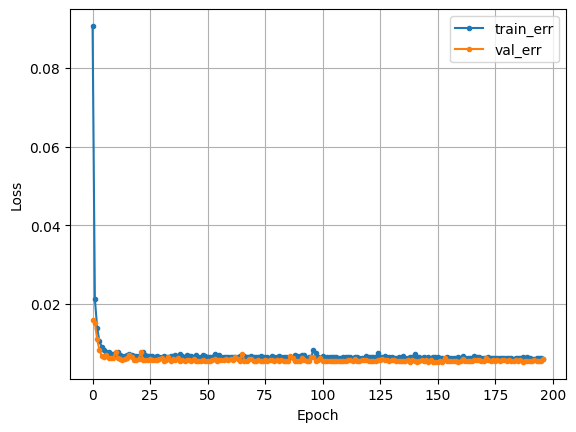

In [60]:
dl_history_plot(hist)

2/2 [==============================] - 0s 8ms/step


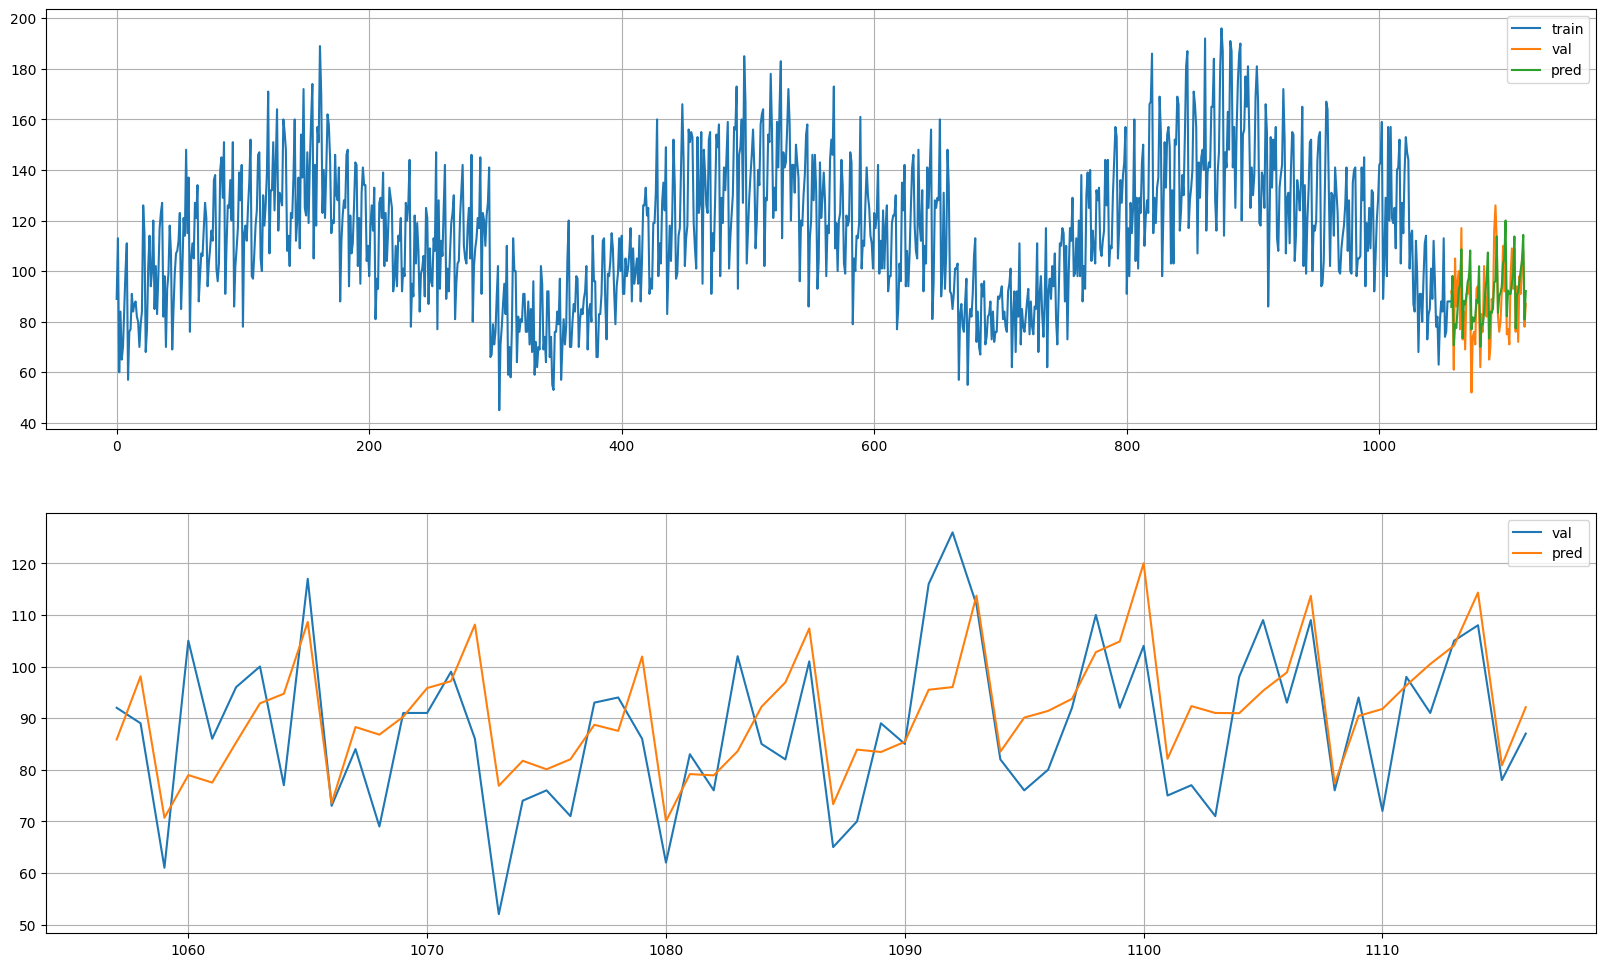

In [61]:
y_pred = model.predict(X_valid_s)
y_pred = scaler.inverse_transform(y_pred)

plot_model_result(y_train, y_valid, y_pred)

In [62]:
print('RMSE :', mean_squared_error(y_valid, y_pred))
print('MAE :', mean_absolute_error(y_valid, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_valid, y_pred))
print('R2  :', r2_score(y_valid, y_pred))

RMSE : 136.95049986249262
MAE : 9.360877736409504
MAPE: 0.11118013861599536
R2  : 0.4045709543653727


## **(2) CNN 초기 모델링**

In [63]:
timesteps = 7
val_size = 60

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [64]:
X = sales_3.drop(['Date', 'target'], axis=1)
y = sales_3['target']
X_3, y_3 = temporalize(X, y, timesteps)

X_train, X_valid, y_train, y_valid = train_test_split(X_3, y_3, test_size = val_size, shuffle = False)

scaler = MinMaxScaler().fit(flatten(X_train))
X_train_s = scale(X_train, scaler)
X_valid_s = scale(X_valid, scaler)
y_train_s = scaler.fit_transform(y_train.reshape(-1, 1))
y_valid_s = scaler.transform(y_valid.reshape(-1, 1))
print(X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape)

(751, 7, 3) (60, 7, 3) (751, 1) (60, 1)


* **모델링**

In [65]:
n_features = X_train_s.shape[2]

clear_session()

model = Sequential([Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                    Flatten(),
                    Dense(1)])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 32)             512       
                                                                 
 flatten (Flatten)           (None, 224)               0         
                                                                 
 dense (Dense)               (None, 1)                 225       
                                                                 
Total params: 737 (2.88 KB)
Trainable params: 737 (2.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
hist = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=10000, callbacks=[es]).history

Epoch 1/10000
24/24 [==============================] - 1s 8ms/step - loss: 0.0151 - val_loss: 0.0153
Epoch 2/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.0132
Epoch 3/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0135
Epoch 4/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0122
Epoch 5/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0122
Epoch 6/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0122
Epoch 7/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0117
Epoch 8/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0115
Epoch 9/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0123
Epoch 10/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0062 - val_lo

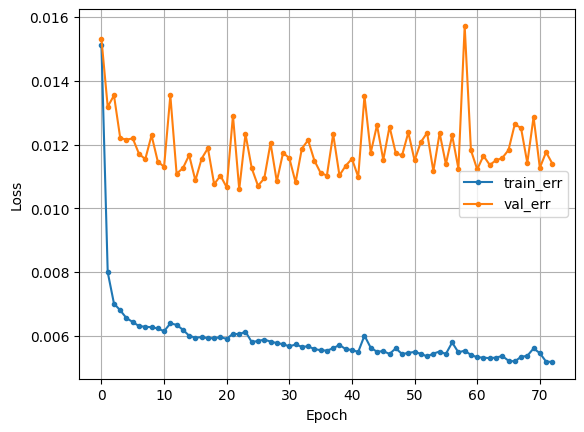

In [67]:
dl_history_plot(hist)

2/2 [==============================] - 0s 5ms/step


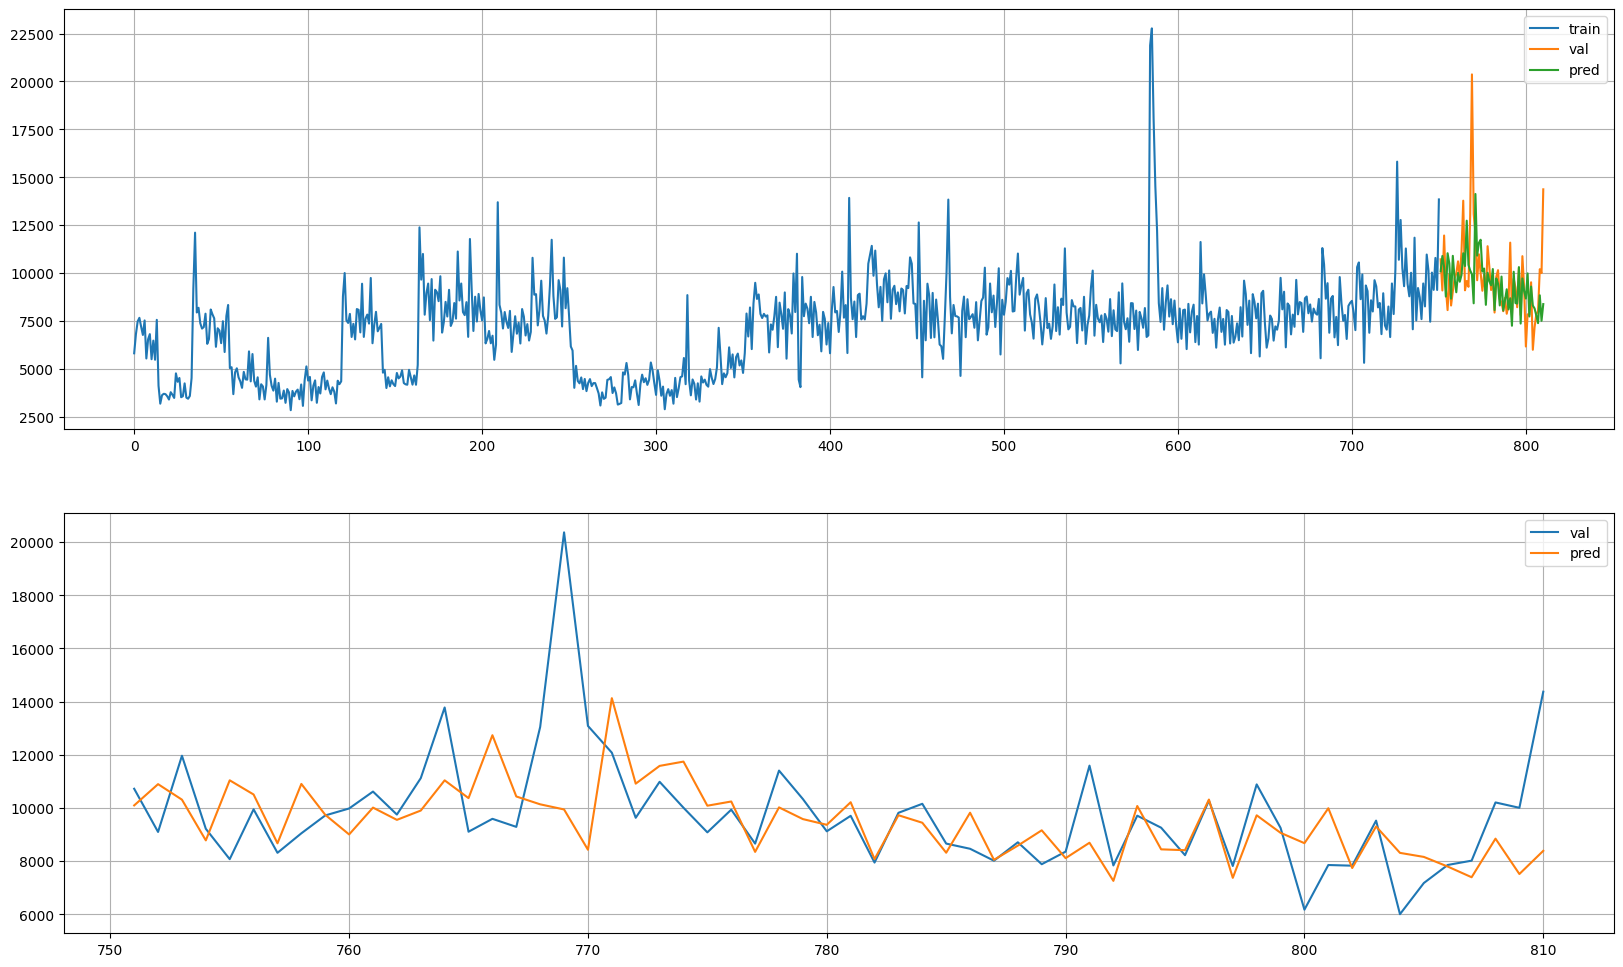

In [68]:
y_pred = model.predict(X_valid_s)
y_pred = scaler.inverse_transform(y_pred)

plot_model_result(y_train, y_valid, y_pred)

In [69]:
print('RMSE :', mean_squared_error(y_valid, y_pred))
print('MAE :', mean_absolute_error(y_valid, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_valid, y_pred))
print('R2  :', r2_score(y_valid, y_pred))

RMSE : 4521773.188478196
MAE : 1325.0229573567708
MAPE: 0.125745030386123
R2  : 0.025882911210100668


### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [70]:
X = sales_12.drop(['Date', 'target'], axis=1)
y = sales_12['target']
X_12, y_12 = temporalize(X, y, timesteps)

X_train, X_valid, y_train, y_valid = train_test_split(X_12, y_12, test_size = val_size, shuffle = False)

scaler = MinMaxScaler().fit(flatten(X_train))
X_train_s = scale(X_train, scaler)
X_valid_s = scale(X_valid, scaler)
y_train_s = scaler.fit_transform(y_train.reshape(-1, 1))
y_valid_s = scaler.transform(y_valid.reshape(-1, 1))
print(X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape)

(751, 7, 3) (60, 7, 3) (751, 1) (60, 1)


* **모델링**

In [71]:
n_features = X_train_s.shape[2]

clear_session()

model = Sequential([Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                    Flatten(),
                    Dense(1)])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 32)             512       
                                                                 
 flatten (Flatten)           (None, 224)               0         
                                                                 
 dense (Dense)               (None, 1)                 225       
                                                                 
Total params: 737 (2.88 KB)
Trainable params: 737 (2.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
hist = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=10000, callbacks=[es]).history

Epoch 1/10000
24/24 [==============================] - 1s 8ms/step - loss: 0.0085 - val_loss: 0.0069
Epoch 2/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0071
Epoch 3/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0071
Epoch 4/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0066
Epoch 5/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0060
Epoch 6/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0070
Epoch 7/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0061
Epoch 8/10000
24/24 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0066
Epoch 9/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0066
Epoch 10/10000
24/24 [==============================] - 0s 5ms/step - loss: 0.0052 - val_lo

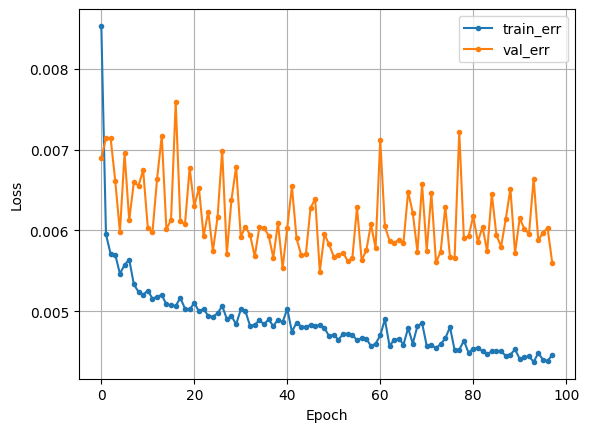

In [73]:
dl_history_plot(hist)

2/2 [==============================] - 0s 5ms/step


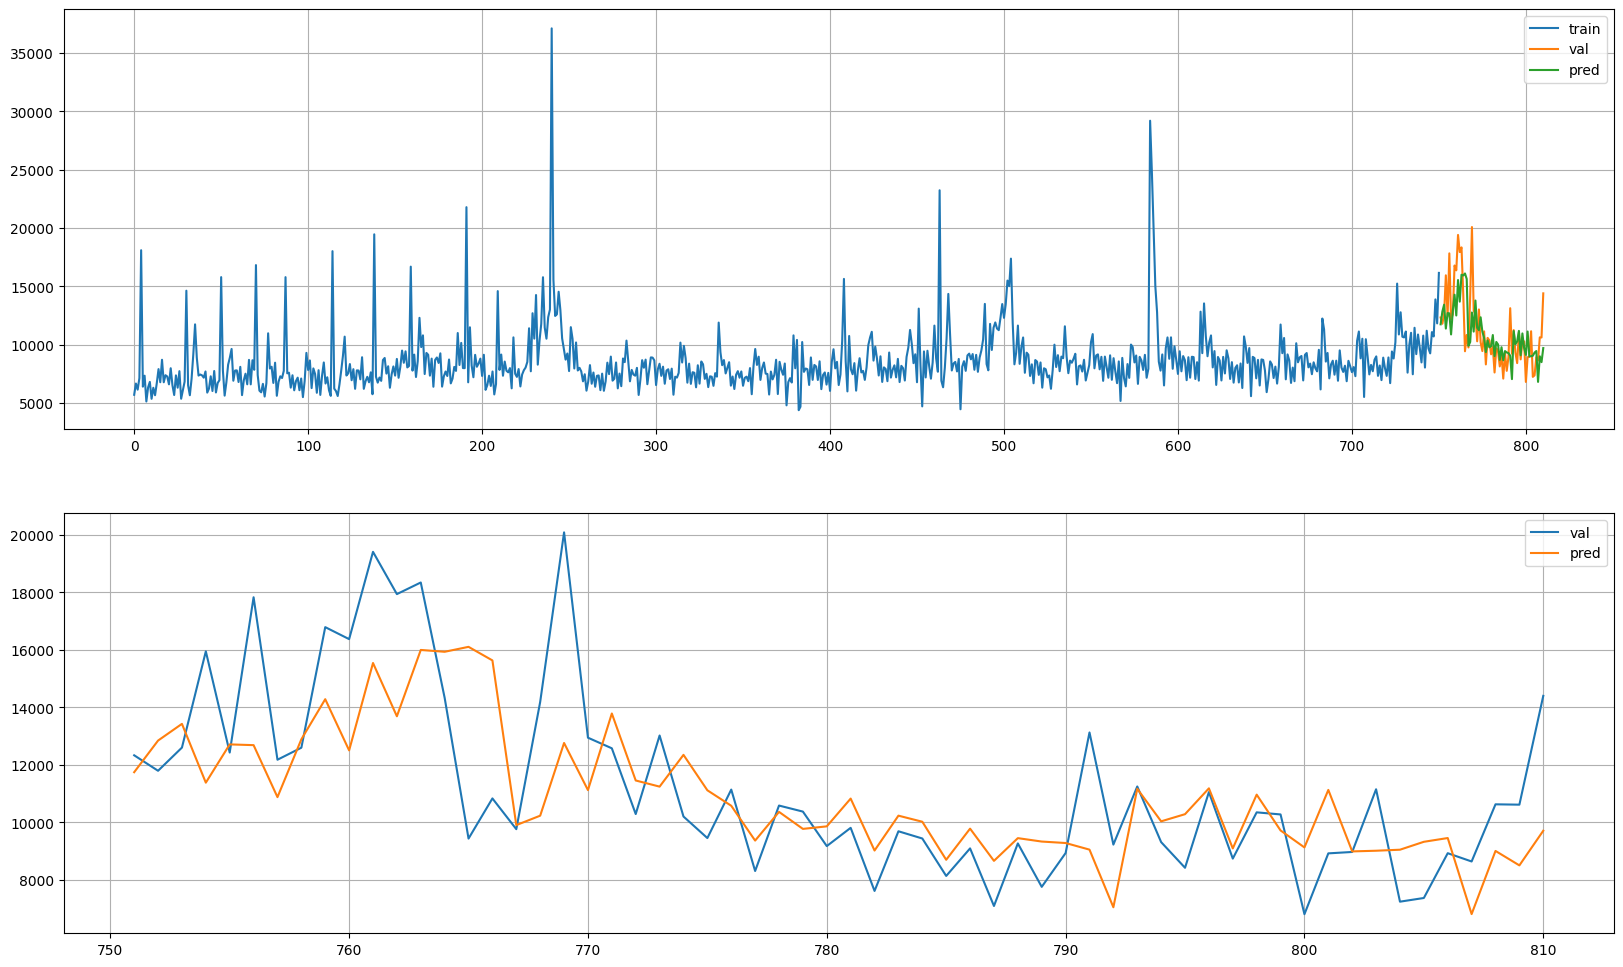

In [74]:
y_pred = model.predict(X_valid_s)
y_pred = scaler.inverse_transform(y_pred)

plot_model_result(y_train, y_valid, y_pred)

In [75]:
print('RMSE :', mean_squared_error(y_valid, y_pred))
print('MAE :', mean_absolute_error(y_valid, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_valid, y_pred))
print('R2  :', r2_score(y_valid, y_pred))

RMSE : 5990295.990886299
MAE : 1808.61357421875
MAPE: 0.15490419031086836
R2  : 0.40656897379545953


### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [76]:
X = sales_42.drop(['Date', 'target'], axis=1)
y = sales_42['target']
X_42, y_42 = temporalize(X, y, timesteps)

X_train, X_valid, y_train, y_valid = train_test_split(X_42, y_42, test_size = val_size, shuffle = False)

scaler = MinMaxScaler().fit(flatten(X_train))
X_train_s = scale(X_train, scaler)
X_valid_s = scale(X_valid, scaler)
y_train_s = scaler.fit_transform(y_train.reshape(-1, 1))
y_valid_s = scaler.transform(y_valid.reshape(-1, 1))
print(X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape)

(1080, 7, 16) (60, 7, 16) (1080, 1) (60, 1)


* **모델링**

In [77]:
n_features = X_train_s.shape[2]

clear_session()

model = Sequential([Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                    Flatten(),
                    Dense(1)])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 32)             2592      
                                                                 
 flatten (Flatten)           (None, 224)               0         
                                                                 
 dense (Dense)               (None, 1)                 225       
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
hist = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=10000, callbacks=[es]).history

Epoch 1/10000
34/34 [==============================] - 1s 7ms/step - loss: 0.0517 - val_loss: 0.0148
Epoch 2/10000
34/34 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0074
Epoch 3/10000
34/34 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0063
Epoch 4/10000
34/34 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 5/10000
34/34 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 6/10000
34/34 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 7/10000
34/34 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 8/10000
34/34 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 9/10000
34/34 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0056
Epoch 10/10000
34/34 [==============================] - 0s 3ms/step - loss: 0.0069 - val_lo

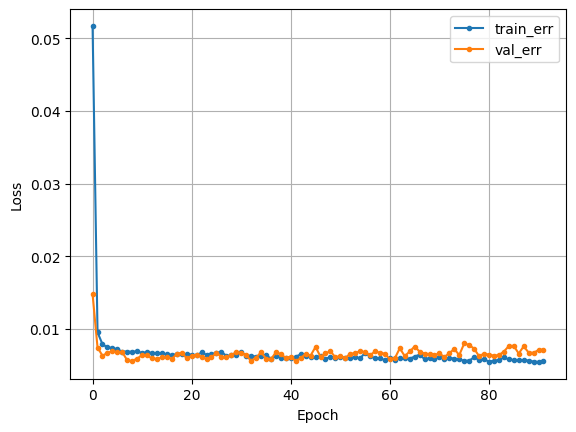

In [79]:
dl_history_plot(hist)

2/2 [==============================] - 0s 4ms/step


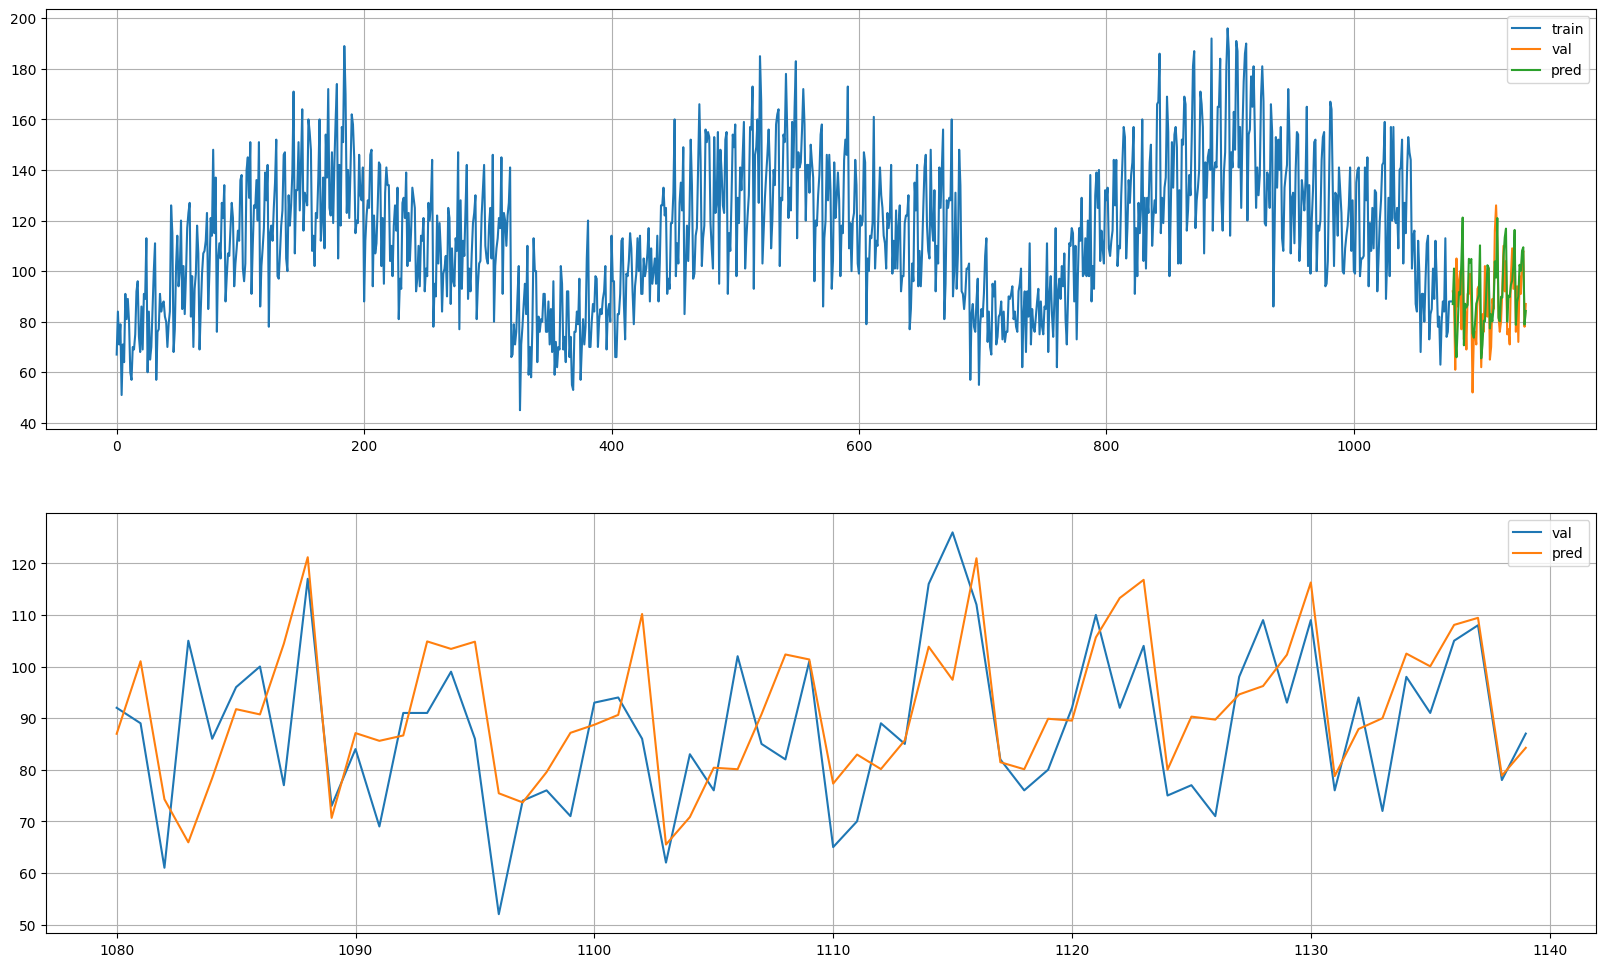

In [80]:
y_pred = model.predict(X_valid_s)
y_pred = scaler.inverse_transform(y_pred)

plot_model_result(y_train, y_valid, y_pred)

In [81]:
print('RMSE :', mean_squared_error(y_valid, y_pred))
print('MAE :', mean_absolute_error(y_valid, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_valid, y_pred))
print('R2  :', r2_score(y_valid, y_pred))

RMSE : 162.97875152907702
MAE : 9.79356320699056
MAPE: 0.11598982890287064
R2  : 0.29140614616873783


# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
joblib.dump(sales_3, path+"sales_3.pkl")

['/content/drive/MyDrive/2024.04.24/sales_3.pkl']

In [ ]:
joblib.dump(sales_12, path+"sales_12.pkl")

['/content/drive/MyDrive/2024.04.24/sales_12.pkl']

In [ ]:
joblib.dump(sales_42, path+"sales_42.pkl")

['/content/drive/MyDrive/2024.04.24/sales_42.pkl']